## Dram Data Upload


In [1]:
import os
import re
import datetime 

import pandas as pd
import numpy as np
import pandas_gbq
import janitor

# Do our imports for the code
from google.cloud import bigquery
from google.oauth2 import service_account

### GBQ Set Up

In this next section we connect to our GBQ project and list the data sets inside to test the connection.

In [2]:
# These first two values will be different on your machine. 
service_path = ""  #change this to your file location
service_file = '' # change this to your authentication information  
gbq_proj_id = '' # change this to your project. 

# And this should stay the same. 
private_key =service_path + service_file

In [3]:
# Now we pass in our credentials so that Python has permission to access our project.
credentials = service_account.Credentials.from_service_account_file(service_path + service_file)

In [4]:
# And finally we establish our connection
client = bigquery.Client(credentials = credentials, project=gbq_proj_id)

In [5]:
for item in client.list_datasets() : 
    print(item.full_dataset_id)

msba-project-2022:dram_shop
msba-project-2022:wedge_dataset


### Checking for existing tables and deleting them

To begin creating an idempotent data pipeline, we will check our Google Big Query project to see if the tables already exist. If they do we will delete them, so we do not upload duplicates.

 

In [6]:
#creating our Regex search pattern

ymd_pattern = re.compile(r"(\d{8})")

In [7]:
dataset_id = "dram_shop"

In [8]:
#Check for existing tables in GBQ

tables = client.list_tables(dataset_id)  

for table in tables:
    
    print(f'Looking at {table.table_id}')

    


Looking at Wedge Task 3 Table 1
Looking at Wedge Task 3 Table 2
Looking at Wedge Task 3 Table 3
Looking at dram_items_20150101
Looking at dram_items_20150301
Looking at dram_items_20150401
Looking at dram_items_20150501
Looking at dram_items_20150601
Looking at dram_items_20150701
Looking at dram_items_20150801
Looking at dram_items_20150901
Looking at dram_items_20151001
Looking at dram_items_20151101
Looking at dram_items_20151201
Looking at dram_items_20160101
Looking at dram_items_20160201
Looking at dram_items_20160301
Looking at dram_items_20160401
Looking at dram_items_20160501
Looking at dram_items_20160601
Looking at dram_items_20160701
Looking at dram_items_20160801
Looking at dram_items_20160901
Looking at dram_items_20161001
Looking at dram_items_20161101
Looking at dram_items_20161201
Looking at dram_items_20170101
Looking at dram_items_20170201
Looking at dram_items_20170301
Looking at dram_items_20170401
Looking at dram_items_20170501
Looking at dram_items_20170601
Looki

In [9]:
table.full_table_id

'msba-project-2022:dram_shop.item-lookup'

In [10]:
#test_table = "dram_items_20150821"
#test_table = "office_hours"

#ymd_pattern.search(test_table)

In [11]:
#the next two lines create my table id in gbq format

#these lines will delete the tables out of gbq if it exists
for table in client.list_tables(dataset_id) :
    if ymd_pattern.search(table.table_id) : 
        table_id = ".".join([gbq_proj_id,dataset_id,table.table_id])
        client.delete_table(table_id, not_found_ok=True)

        print(f"Deleted {table.table_id}.")

Deleted dram_items_20150101.
Deleted dram_items_20150301.
Deleted dram_items_20150401.
Deleted dram_items_20150501.
Deleted dram_items_20150601.
Deleted dram_items_20150701.
Deleted dram_items_20150801.
Deleted dram_items_20150901.
Deleted dram_items_20151001.
Deleted dram_items_20151101.
Deleted dram_items_20151201.
Deleted dram_items_20160101.
Deleted dram_items_20160201.
Deleted dram_items_20160301.
Deleted dram_items_20160401.
Deleted dram_items_20160501.
Deleted dram_items_20160601.
Deleted dram_items_20160701.
Deleted dram_items_20160801.
Deleted dram_items_20160901.
Deleted dram_items_20161001.
Deleted dram_items_20161101.
Deleted dram_items_20161201.
Deleted dram_items_20170101.
Deleted dram_items_20170201.
Deleted dram_items_20170301.
Deleted dram_items_20170401.
Deleted dram_items_20170501.
Deleted dram_items_20170601.
Deleted dram_items_20170701.
Deleted dram_items_20170801.
Deleted dram_items_20170901.
Deleted dram_items_20171001.
Deleted dram_items_20171101.
Deleted dram_i

### Reading in and uploading montly tables

In [12]:
# Here's a function to transform the date column in a dataframe to 
# the YYYYMM01 format we'd like to use for subsetting.

def reformat_date(date_string) :
    date_string = datetime.datetime.strptime(date_string,"%Y-%m-%d")
    return(datetime.date.strftime(date_string,"%Y%m")+"01")

assert(reformat_date("2022-09-20")=="20220901")
assert(reformat_date("2000-10-20")=="20001001")


# Reading in Local Files

In [13]:
#First let's get our files
input_files = os.listdir('dram_items\\')
print(input_files)

['items-2015-01-01-2016-01-01.csv', 'items-2016-01-01-2017-01-01.csv', 'items-2017-01-01-2018-01-01.csv', 'items-2018-01-01-2019-01-01.csv', 'items-2019-01-01-2020-01-01.csv', 'items-2020-01-01-2021-01-01.csv', 'items-2021-01-01-2022-01-01.csv', 'items-2022-01-01-2022-10-01.csv', 'items-2022-01-01-2023-01-01.csv']


Read in the local data files and store them to our df list.

In [14]:
df_list = []

for file in input_files :
    df = pd.read_csv(file)
    df_list.append(df) 

C:\Users\ofano\AppData\Local\Temp\ipykernel_9020\81214954.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\ofano\AppData\Local\Temp\ipykernel_9020\81214954.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\ofano\AppData\Local\Temp\ipykernel_9020\81214954.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\ofano\AppData\Local\Temp\ipykernel_9020\81214954.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\ofano\AppData\Local\Temp\ipykernel_9020\81214954.py:6: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\ofano\AppData\Local\Temp\ipykernel_9020\812149

In [15]:
#type(df_list[0])
#df_list[0].dtypes

# Formatting our Dataframes

In [16]:
## format each df
clean_dfs = []
for df in df_list :
    df['Gross Sales'] = df["Gross Sales"].str.replace('$', '').str.replace(',','')
    df['Gross Sales'] = pd.to_numeric(df['Gross Sales'])

    df['Discounts'] = df["Discounts"].str.replace('$', '').str.replace(',','')
    df['Discounts'] = pd.to_numeric(df['Discounts'])

    df['Net Sales'] = df["Net Sales"].str.replace('$', '').str.replace(',','')
    df['Net Sales'] = pd.to_numeric(df['Net Sales'])

    df['Tax'] = df["Tax"].str.replace('$', '').str.replace(',','')
    df['Tax'] = pd.to_numeric(df['Tax'])

    df['Modifiers Applied'] = df['Modifiers Applied'].astype('str')

    df['SKU'] = df['SKU'].replace(np.nan, '', regex=True)

    df = janitor.clean_names(df)
    clean_dfs.append(df)

C:\Users\ofano\AppData\Local\Temp\ipykernel_9020\160286705.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Gross Sales'] = df["Gross Sales"].str.replace('$', '').str.replace(',','')
C:\Users\ofano\AppData\Local\Temp\ipykernel_9020\160286705.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Discounts'] = df["Discounts"].str.replace('$', '').str.replace(',','')
C:\Users\ofano\AppData\Local\Temp\ipykernel_9020\160286705.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Net Sales'] = df["Net Sales"].str.

# Uploading Formatted Dataframes to GBQ

In [17]:
## now iterate over the data frames and upload them

for df in clean_dfs :
    df["ym"] = df["date"].map(reformat_date)

    ym_list = df['ym'].unique().tolist()
    ym_list
    break


    for ym in ym_list:
        
        dram_items = df.query(f'ym == "{ym}"')
        table_name = (f'dram_items_{ym}')
        table_id = ".".join([gbq_proj_id,dataset_id,table_name])
        pandas_gbq.to_gbq(dram_items,table_id,project_id=gbq_proj_id,if_exists="replace")
        
        


### Querying the Results

Here I'll write a query to return the number of records per month across all of the tables I previously uploaded into Google Big Query.

In [40]:
query_1 = """
        SELECT ym as month,
        count(date) as count 
        FROM `msba-project-2022.dram_shop.dram_items_20*`
        GROUP BY ym
        order BY ym ASC"""

month_count = pandas_gbq.read_gbq(query_1,project_id = gbq_proj_id)

Downloading: 100%|██████████| 49/49 [00:00<00:00, 190.58rows/s]


In [43]:
#month_count

# Plotting the Results

<AxesSubplot:xlabel='month'>

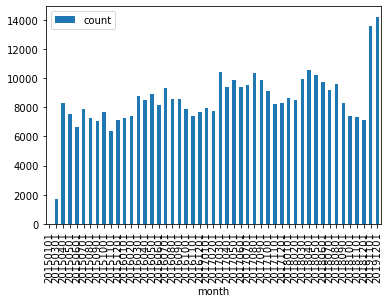

In [42]:
month_count.plot(x='month', y='count', kind='bar')